## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:
Валігурський Антон, Денисова Ірина, Кравчук Андрій
- Валігурський Антон - lzw, deflate
- Денисова Ірина - lz77
- Кравчук Андрій - haffman 

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

In [1]:
import random, string
import matplotlib.pyplot as plt
from time import time

def randomword(length):
   letters = string.ascii_lowercase
   return ''.join(random.choice(letters) for i in range(length))

lengths = range(1,10001, 1000)


# Алгоритм Гаффмана

В цьому алгоритмі доцільно імплементувати клас node та додаткові функції в Huffman для побудови дерева кодування

In [2]:
class Huffman:
    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        pass

    def decode(self, code: str, coding_dict: dict[str, str]):
        pass

# Алгоритм LZW

In [3]:
class LZW:
    def encode(self, text: str) -> tuple[str, list]:
        i = 0
        len_ = len(text)
        code = []

        start_dict = list(set(text))
        dict_ = start_dict[:]

        new_entry = ""
        while i < len_:
            new_entry += text[i]
            i += 1
            if new_entry not in dict_:
                dict_.append(new_entry)
                code.append(dict_.index(new_entry[:-1]))
                new_entry = ""
                i -= 1
                
        if new_entry not in dict_:
            dict_.append(new_entry)
        code.append(dict_.index(new_entry))
        
                
        return code, start_dict

        
    def decode(self, code: str, coding_dict: list) -> str:
        decoded_text = ""
        i = 0

        for symb in code:
            symb = int(symb)
            if int(symb) >= len(coding_dict):
                while len(coding_dict) <= symb:
                    new_entry = decoded_text[i]
                    i += 1
                    while i < len(decoded_text) and new_entry in coding_dict:
                        new_entry += decoded_text[i]
                        i += 1
                    if new_entry in coding_dict:
                        for new_char in new_entry:
                            new_entry += new_char
                            i+=1
                            if new_entry not in coding_dict:
                                break

                    coding_dict.append(new_entry)
                    i -= 1
            decoded_text += coding_dict[symb]

        return decoded_text







# Алгоритм LZ77

Потрібно заміряти розміри саме тексту, проте для роботи доцільно використовувати список тюплів, тому для зручності варто імплементувати додаткові алгоритми _text2list та _list2text

In [4]:
class LZ77:
    def __init__(self, buffer_size: int):
        pass

    def encode(self, text: str) -> str:
        pass

    def decode(self, code: str) -> str:
        pass

# Алгоритм Deflate

In [5]:
class Deflate:
    def __init__(self, buffer_size: int):
        pass

    def encode(self, text: str) -> str:
        pass

    def decode(self, code: str) -> str:
        pass

# Testing

LZW compression percentage
0.5
0.7019635343618513
0.788726842727631
0.8571836618109112
0.8966831017480951
0.9493166287015945
0.9308205366837289
0.9726312864684634
0.9916955875061974
0.9983362910381544
LZW compression percentage


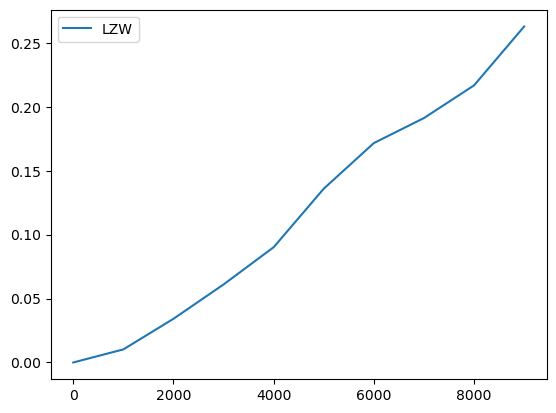

In [6]:
X = [i for i in lengths]
Y = []

beg = 1
print("LZW compression percentage")
for i in lengths:

    to_code = randomword(i)
    start = time()
    code, dict_ = LZW().encode(to_code)
    decoded = LZW().decode(code, dict_)
    Y.append(time()-start)
    assert to_code == decoded
    
    print("LZW effectivenes:",i / (len(code) + len(dict_)))
    
    
plt.plot(X, Y, label = "LZW")
plt.xlabel = "length of string"
plt.ylabel = "time perfomance"

plt.legend()
plt.show()


### LZW
Очевидно, що зі зростанням кількості елементів в повідомленні, час стиснення відповідно зростає. На жаль, через повільнісь мови програмування Python нам не вдастся перевірити ефективність стиснення на повну, адже алгоритм розкриваєтсья на повну потужність на великих файлах, таких як картинки, в яких дуже багато повторен. Це можна довести тим, що зі збільшенням елементів відслідковується збільшення ефективності стиснення.